# Preliminaries

In [13]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

from dropout_prediction.data_loader.data_loader import UCLDataLoader
from dropout_prediction.preprocessing.preprocess import preprocess_pipeline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [2]:
DATE_START = "2021-07-21"
DATE_END = "2022-01-31"

data_loader = UCLDataLoader()
raw_data = data_loader.load_data(DATE_START, DATE_END)

100%|██████████| 195/195 [00:32<00:00,  5.92it/s]


In [3]:
raw_data = preprocess_pipeline(raw_data)

# Missingness

In [6]:
complete  = raw_data[raw_data.notna()].groupby(pd.Grouper(key = 'Date', freq = "D")).count()
alls = raw_data.groupby(pd.Grouper(key = 'Date', freq = "D")).count()
#a = (alls == complete) 
completeness = complete/alls
completeness = completeness.fillna(0)
completeness.plot()

- Data from August has been split into x and y. We should understand this. 
- Data from before june is sparse. 
- ExternalUserId and UserId are bad labels

# Variables

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800294 entries, 0 to 5476
Data columns (total 54 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   esas_studiestart                      800294 non-null  datetime64[ns]
 1   esas_forventet_afslutning             798882 non-null  datetime64[ns]
 2   esas_afgangsdato                      22216 non-null   datetime64[ns]
 3   Uddannelse                            800294 non-null  object        
 4   esas_dst_kode                         800294 non-null  int64         
 5   esas_rolle                            800294 non-null  int64         
 6   esas_iso2                             800294 non-null  object        
 7   esas_studieemail                      800294 non-null  object        
 8   esas_by                               800294 non-null  object        
 9   esas_postnummer                       800294 non-null  int64 

In [10]:
print(raw_data['esas_studieforloebId'].nunique())
print(raw_data['esas_studieemail'].nunique())

6152
6131


Der er flere studieemails end der er studieforløb. Det indikerer at studerende kan skifte email og at esas_studieforloebId er den key vi skal aggregere op over. 

## Categorical features

In [11]:
# looking at categorical features
pd.options.plotting.backend = "matplotlib"
cats = [c for c in raw_data.columns if raw_data[c].dtype == object]

print(cats)
raw_data[cats].head()



['Uddannelse', 'esas_iso2', 'esas_studieemail', 'esas_by', 'esas_studieforloebId', 'Person_label', 'Afgangsaarsag', 'esas_bestaaet', 'esas_taeller_som_forsoeg', 'esas_karakter']


Uddannelse esas_iso2  \
0  PB Digital konceptudvikling (ob)        DK   
1            PB Socialrådgiver 2012        DK   
2           PB Folkeskolelærer 2015        DK   
3                  PB Sygeplejerske        DK   
4                   PB Pædagog 2014        DK   

                                    esas_studieemail        esas_by  \
0  4d2d2dafb05a5c003bcf9d6bfd020a56a701de509786ae...    København K   
1  e58dadec67aa04c3170a8d69d74eccc708b7d593aaa80d...  Frederikshavn   
2  7d55e7c13ce687a7dc96112e9df3ddc143d12991d99b5b...       Hornslet   
3  0a78d8d0659747f8ab01681481a5c9e5ad740dbef085f9...       Odense M   
4  a82a0d02a2c7edba634fc24cc1826e99c38f0d57814bf0...       Odense M   

                   esas_studieforloebId     Person_label Afgangsaarsag  \
0  630A0A71-B86D-EB11-A2FA-005056B24458  Bopæl i Danmark           NaN   
1  99060A71-B86D-EB11-A2FA-005056B24458  Bopæl i Danmark           NaN   
2  1E0C0A71-B86D-EB11-A2FA-005056B24458  Bopæl i Danmark           NaN   
3  04FD0971-B86D-EB11-A2FA-005056B24458  Bopæl i Danmark           NaN   
4  59FB116B-B86D-EB11-A2FB-005056B296A0  Bopæl i Danmark           NaN   

  esas_bestaaet esas_taeller_som_forsoeg esas_karakter  
0          True                     True            10  
1          True                     True            10  
2          True                     True    G Godkendt  
3          True                     True    G Godkendt  
4          True                     True             7

It makes sense to look at "Uddannelse", "esas_iso2", "esas_by", "Uddannelses_label", "Person_label", "Afgangsaarsag", "esas_bestaaet", "esas_taeller_som_forsoeg", "esas_karakter". 

TypeError: bar() got an unexpected keyword argument 'ax'

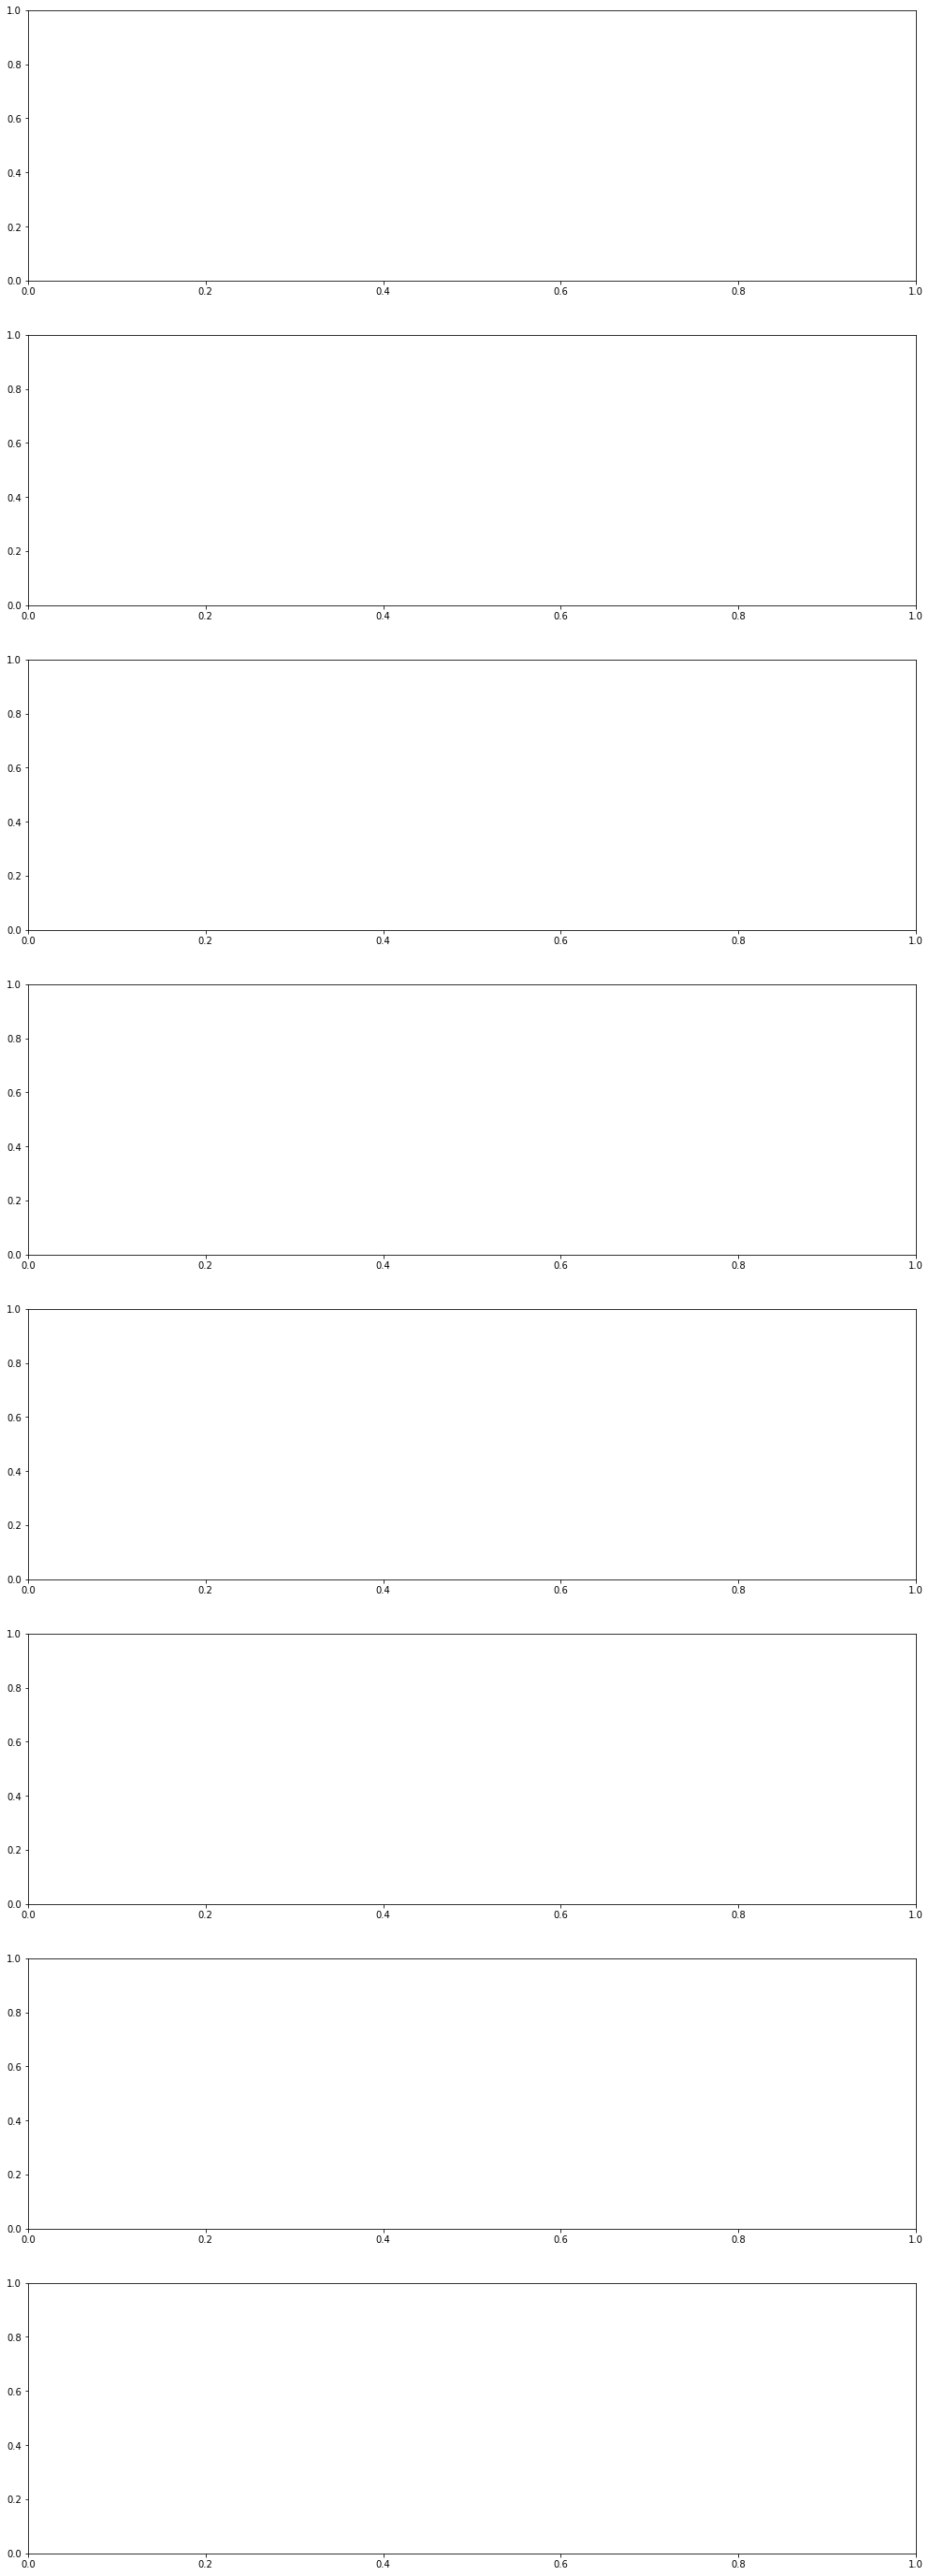

In [15]:
categorical_plot = ["Uddannelse",
                    "esas_iso2",
                    "esas_by", 
                    "Person_label", 
                    "Afgangsaarsag", 
                    "esas_bestaaet", 
                    "esas_taeller_som_forsoeg", 
                    "esas_karakter"
                    ]
fig, axs = plt.subplots(nrows =len(categorical_plot), ncols= 1 , figsize = (17, 50))

for i, c in enumerate(categorical_plot):
   raw_data[c].value_counts().plot(kind = "bar", ax = axs[i]).set_title(c)

plt.tight_layout()
plt.show()


esas_iso2 is almost exclusively DK. This column should be removed. 

/var/folders/_4/wsjjwycx0mlczsjf4qyskxlm0000gq/T/ipykernel_87548/4234775726.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



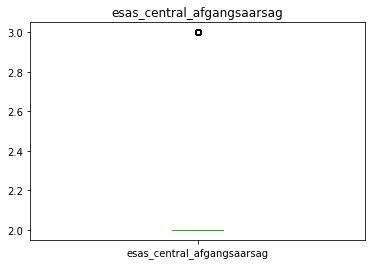

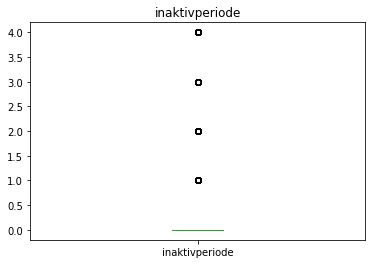

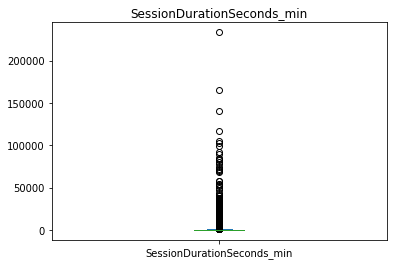

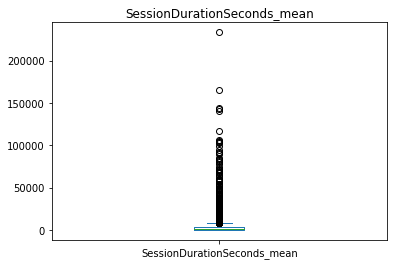

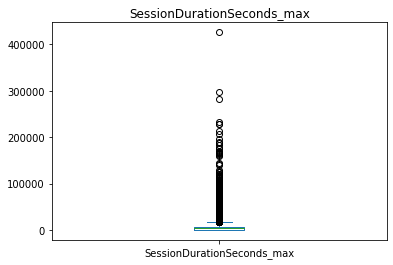

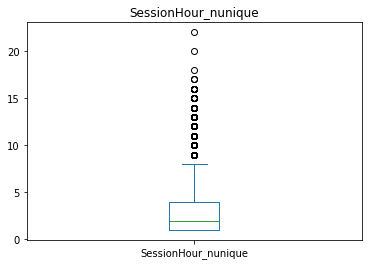

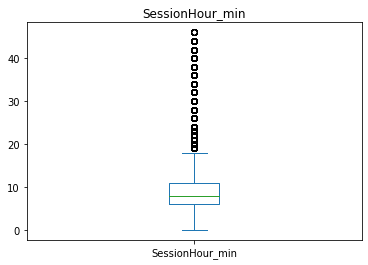

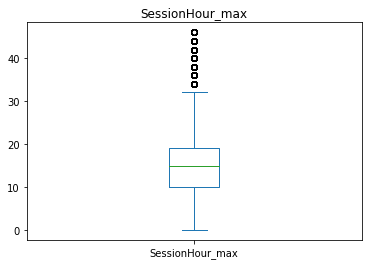

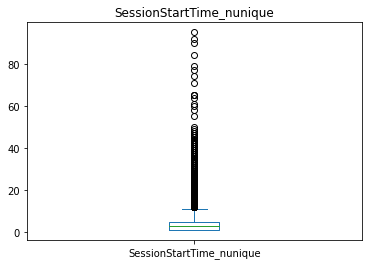

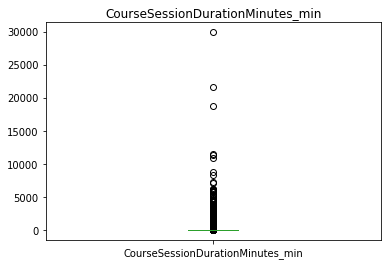

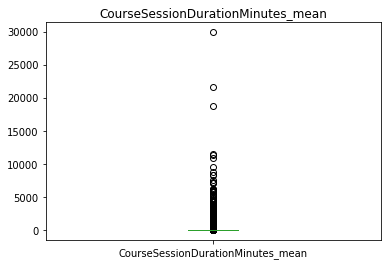

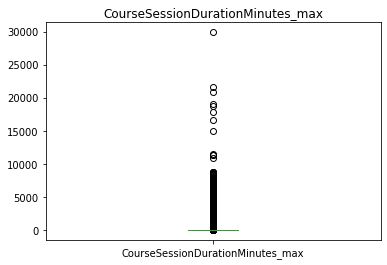

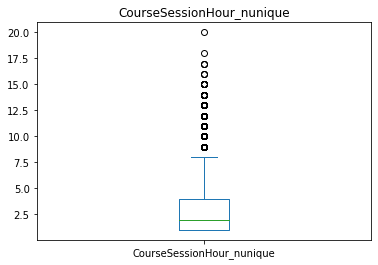

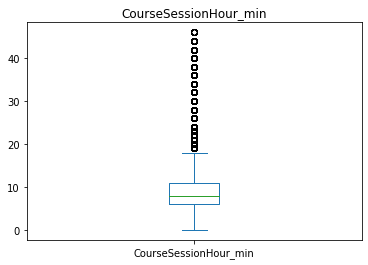

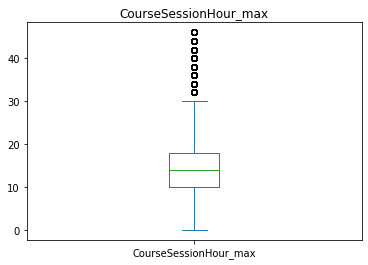

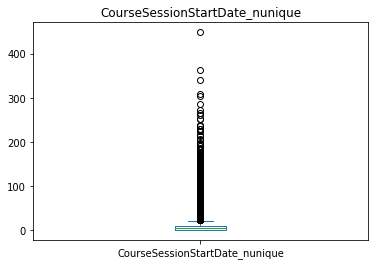

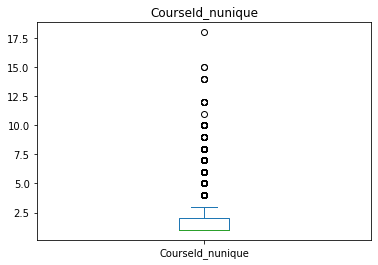

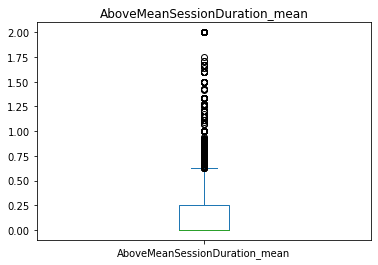

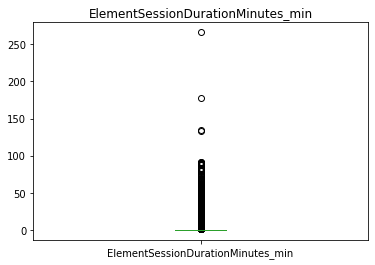

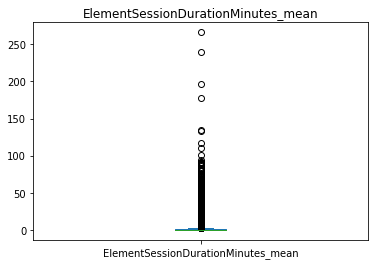

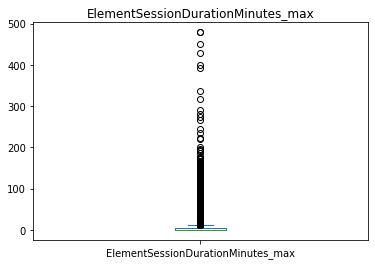

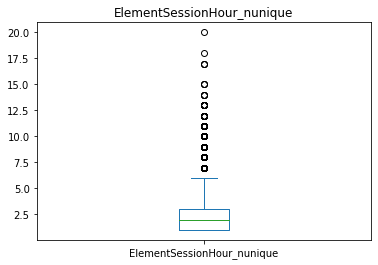

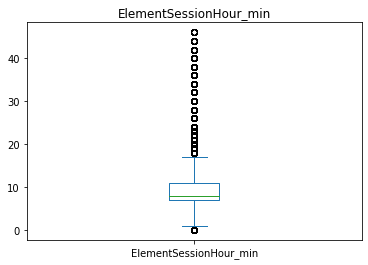

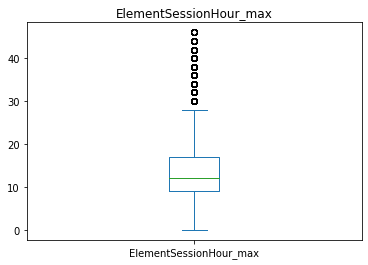

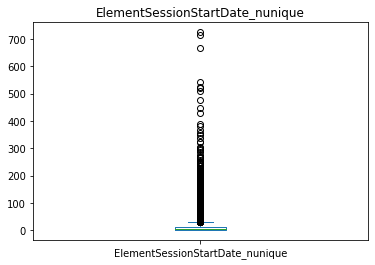

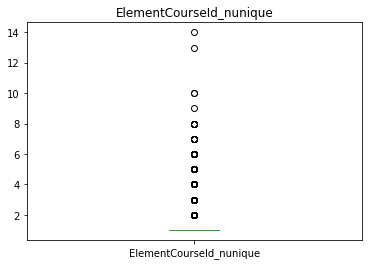

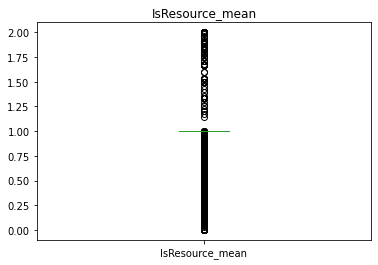

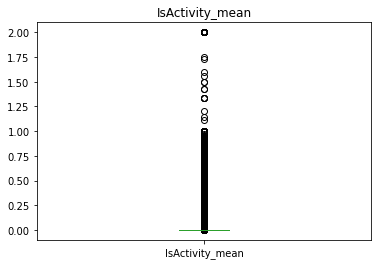

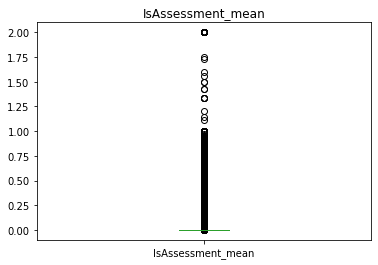

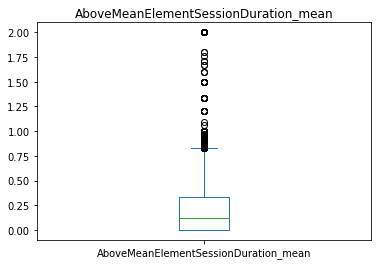

In [17]:
# looking at numerical features
pd.options.plotting.backend = "matplotlib"
numeric = [n for n in raw_data.columns if raw_data[n].dtype == float]

for i, numeric_feature in enumerate(raw_data[numeric]):
    fig = plt.figure();
    raw_data[numeric_feature].plot.box().set_title(numeric_feature);
    # plt.savefig(f"dropout_prediction/plots/numeric_{numeric_feature}.png");



# Explorative Analysis

## Features representation

### Correlation

In [ ]:
# Heatmap of numerical variables with correlation greater than 0.5 

numeric = [n for n in raw_data.columns if raw_data[n].dtype == float]
num = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#newdf = raw_data.select_dtypes(include=num)

corr = raw_data[numeric].corr()
kot = corr[corr.abs()>=.5]

f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure the colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(kot, annot=True, mask = mask, cmap=cmap)

Inverse correlation between IsResource_mean, IsAssessment_mean and IsActivity_mean. High correlation between IsAssessment_mean and IsActivity_mean.
The earliest and the latest hour students connect to the system is, most of the times, to attend a class (high correlation between ElementSessionHour_min(max) and CourseSessionHour_min(max)).

### Feature analysis

The 'Afgangsaarsag' feature corresponds to the exatct date in which a student drop out from its education. All the data from that student before that time is considered as a non-dropout. It makes sense to add another feature that assings a dropout label to all the activiy from that student, even before dropping out. In order to do so, we make a mapping and add it to the dataframe as a new feature 'dropout_label'.

In [ ]:
# Create a dictionary between the unique students and drops 
mapping = raw_data.groupby('esas_studieforloebId').agg({'Afgangsaarsag' : 'first'}).to_dict()['Afgangsaarsag']
# Mapping the dictionary to the dataframe by adding a new column
raw_data['dropout_label'] = raw_data['esas_studieforloebId'].map(mapping).astype(str)
# Creating a new feature similar to esas_central_afgangsaarsag but for dropout level
#conditions = [(raw_data['dropout_label'] == 'None'),(raw_data['dropout_label'] == 'Administrativ udskrivning - Ikke påbegyndt uddannelsen'), (raw_data['dropout_label'].notna() != 'Administrativ udskrivning - Ikke påbegyndt uddannelsen')]
#actions = [np.nan,3,2]
#raw_data['esas_central_dropout'] = np.select(conditions, actions, default='Other').astype(float)

Now we can split the dataframe between drops and nondrops based on the 'dropout_label' column.

In [ ]:
# Dropout and non-dropout dataframes
df_unique_drop = raw_data[raw_data['dropout_label'] != 'None']
column = pd.Series(np.arange(0,len(df_unique_drop),1), name='column')
df_unique_drop = df_unique_drop.reset_index()
df_unique_drop = pd.concat([column,df_unique_drop],axis=1)
# df_unique_drop['dropout_label'].value_counts(dropna=False)

In [ ]:
df_unique_nondrop = raw_data_drops[raw_data_drops['dropout_label'] == 'None']
columns = pd.Series(np.arange(0,len(df_unique_nondrop),1), name='columns')
df_unique_nondrop = df_unique_nondrop.reset_index()
df_unique_nondrop = pd.concat([columns,df_unique_nondrop],axis=1)
#df_unique_nondrop

##### When do students drop out and why?

In [ ]:
# Creating a dataframe with the different reasons of dropping out 
df_reasons = df_unique_drop.groupby('esas_studieforloebId').agg( {'Date': 'first', 'Afgangsaarsag' : 'first', 'dropout_label' : 'first'})
df_reasons = df_reasons.reset_index()
df_reasons = df_reasons.reset_index()
df_reasons

In [ ]:
# plotting the distribution of the dropout reasons 
pd.options.plotting.backend = "plotly"
# import plotly_express as px
df_reasons.groupby([pd.Grouper(key='Date', freq = 'D'),pd.Grouper(key='Afgangsaarsag',axis=0)]).index.count().unstack().reset_index().fillna(0).plot.scatter(x='Date', y =  ['Udmeldelse - Fortrudt valg af uddannelse', 'Udmeldelse - Ukendt årsag', 'Administrativ udskrivning - Ikke påbegyndt uddannelsen',
'Overflytning - Skift til anden institution','Administrativ udskrivning - Prøveforsøg opbrugt','Udmeldelse - Studiekrav for høje',
   'Administrativ udskrivning - Manglende studieaktivitet','Ikke opfyldt betinget optag', 'Studerendes dødsfald'] )

It looks like there can be 2 months between the first dropout dates are assigned. But here we are only assessing the first dropout. There are some that drop out than once. 

#### Activity of the students that drop out - which students are more active before dropping out?

In [ ]:
import plotly.graph_objects as go

import numpy as np

import plotly.express as px

# Distribution of dropouts
df_unique_drop.groupby('Afgangsaarsag').count()['index'].plot.bar()

fig = go.Figure()
    
fig.add_trace(go.Histogram(name="Afgangsaarsag",x=df_unique_drop['Afgangsaarsag'], nbinsx = 200,  histnorm='probability', opacity = 0.8))
fig.add_trace(go.Histogram(name="dropout_label",x=df_unique_drop['dropout_label'], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
fig.update_layout(barmode='group',title_text= f'Distribution of dropouts', xaxis_title_text = 'dropouts', yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

Students that drop out because they regretted their chooice of education are active in the system before they drop out. Also students from unkown reasons.

#### Do the students that drop out pass their exams?

In [ ]:
fig = go.Figure()
    
fig.add_trace(go.Histogram(name="drops",x=df_unique_drop['esas_karakter'], nbinsx = 200,  histnorm='probability', opacity = 0.8))
fig.add_trace(go.Histogram(name="nondrops",x=df_unique_nondrop['esas_karakter'], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
fig.update_layout(barmode='group',title_text= f'Distribution of grades', xaxis_title_text = 'uddannelse', yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

More than half of the students that drop out pass their courses, 23% percent perform good, and the rest didn't meet the requirements to pass.

#### In which types of education do student drop out the most?

In [ ]:
fig = go.Figure()
    
fig.add_trace(go.Histogram(name="drops",x=df_unique_drop['Uddannelse'], nbinsx = 200,  histnorm='probability', opacity = 0.8))
fig.add_trace(go.Histogram(name="nondrops",x=df_unique_nondrop['Uddannelse'], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
fig.update_layout(barmode='group',title_text= f'Distribution of educations', xaxis_title_text = 'uddannelse', yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

High percentage of dropouts in AK Automationsteknolog, which is teached in Fredericia(7000) og Odense(5000,5230) campus; Laborant in Odense; IT-teknolog in Odense; Produktionsteknolog in Odense; Financial Cotroller in Odense; Datamatiker in Odense og Vejle(7100); Sundhedsadministrativ koordinator in Odense; Jordbrugsteknolog in Odense; Innovation og entrepreneurship in Odense; Digital konceptudvikling in Odense; El-installatør in Odense og Vejle; Sportsmanagement in Odense; Jordbrug in Odense; Logistikøkonom in Vejle.

Most of them are technical degrees. Also, most of them occur in Odense, but because it has two campus and it is probably the one that offers more types of education.

#### Distribution of numerical features

In [ ]:
numeric = [n for n in raw_data_drops.columns if n not in ['esas_dst_kode','esas_rolle','esas_cpr_personstatus', 'esas_uddannelsestype', 'Weekday'] if raw_data_drops[n].dtype == int or raw_data_drops[n].dtype == float ]

for i, numeric_feature in enumerate(numeric):

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(name="drops",x=df_unique_drop[numeric_feature], nbinsx = 200,  histnorm='probability', opacity = 0.8))
    fig.add_trace(go.Histogram(name="nondrops",x=df_unique_nondrop[numeric_feature], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
    fig.update_layout(barmode='group',title_text= f'Distribution of {numeric_feature}', xaxis_title_text = numeric_feature, yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.75)
    fig.show()

Comments on esas_postnummer: The postal codes corresponding to the two ucl campus in Odense are the ones registering more activity of students that dropout and students that finsihed their education.

In [ ]:
# Computing the cumulative distribution function of the numerical variables
pd.options.plotting.backend = "matplotlib"

fig, axs = plt.subplots(nrows =len(numeric), ncols= 1 , figsize = (17, 100), sharey = True)


for i, num in enumerate(numeric):

   df_unique_nondrop[num].hist(cumulative = True, bins =100, density = True, histtype= 'step', ax = axs[i], color = 'indianred', label = 'non-drop')
   df_unique_drop[num].hist(cumulative = True, bins =100, density = True, histtype= 'step', ax = axs[i], color = 'blueviolet', label = 'drop')
   axs[i].set_title(num)
   axs[i].set_title(num)
   axs[i].set_ylabel('counts')
   axs[i].legend('non-drop')
   axs[i].legend('drop')

The cumulative distribution measures the probability of the data to be less than or equal to a certain value. This means, the cumulative probability for a certain value. Therefore, it contains infromation about the distribution of values. If we reach a probability really close to one in the begginnig of the distribution this means that the distribution is centered in the begginning and that probably the rest of the values have a small weights and therefore can be removed without actual change in the data. This is what we call outliers. Hence, in order to see if there are outliers, wwe have to look at the shape of the cumulative distribution.

With this in mind, and by looking at the plots, the columns that certainly present outliers are the ones that reach one in the very begginning of the disfribution

##### Patricularizing for the first 30min of a session

In [ ]:
#df = df_unique_drop[(df_unique_drop["SessionDurationSeconds_min"] >= 600) & (df_unique_drop["SessionDurationSeconds_min"] <= 690) ]
df = df_unique_drop[(df_unique_drop["SessionDurationSeconds_min"] < 1800)]
df_non = df_unique_nondrop[(df_unique_nondrop["SessionDurationSeconds_min"] < 1800)]
#df_non = df_unique_nondrop[(df_unique_nondrop["SessionDurationSeconds_min"] >= 600) & (df_unique_nondrop["SessionDurationSeconds_min"] <= 690) ]

for i, numeric_feature in enumerate(numeric):

    fig = go.Figure()
    
    fig.add_trace(go.Histogram(name="drops",x=df[numeric_feature], nbinsx = 200,  histnorm='probability', opacity = 0.8))
    fig.add_trace(go.Histogram(name="nondrops",x=df_non[numeric_feature], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
    fig.update_layout(barmode='group',title_text= f'Distribution of {numeric_feature}', xaxis_title_text = numeric_feature, yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.75)
    fig.show()

In [ ]:
# numeric columns from which we will remove the outliers
numeric = [n for n in raw_data_drops.columns if raw_data_drops[n].dtype == float]
lista = ['esas_central_afgangsaarsag', 'inaktivperiode', 'SessionHour_nunique', 'SessionHour_min', 'SessionHour_max', 'CourseSessionDurationMinutes_min', 'CourseSessionHour_nunique', 'CourseSessionHour_min', 'CourseSessionHour_max',
                                'CourseId_nunique', 'AboveMeanSessionDuration_mean', 'ElementSessionDurationMinutes_min', 'ElementSessionHour_nunique', 'ElementSessionHour_min', 'ElementSessionHour_max', 'ElementCourseId_nunique', 'IsResource_mean',
                                'IsActivity_mean','IsAssessment_mean','AboveMeanElementSessionDuration_mean', 'esas_central_dropout','esas_postnummer']
column_list = [elem for elem in numeric if elem not in lista]
#column_list

#### Removing outliers

In [ ]:
def remove_outliers(dataset, columns, number):
    """Remove the outliers of certain columns in a dataset by computing the quantiles"""
    dataset_out = dataset[columns]
    Q1 = dataset_out.quantile(0.25) #first quantile
    Q3 = dataset_out.quantile(0.75) #third quantile
    IQR = Q3 - Q1 #interquantile
    # Removing outliers 
    dataset_out = dataset_out[~((dataset_out < (Q1 - number * IQR)) |(dataset_out > (Q3 + number * IQR))).any(axis=1)]
    percentage = 100 - len(dataset_out)*100/len(dataset)
    print('Percentage of removed data is', "%.3f" % percentage)
    return dataset_out

Removing outliers from dropout and non-dropout dataframes

In [ ]:
df_unique_nondrop_out = remove_outliers(df_unique_nondrop, column_list, 14)
df_unique_drop_out = remove_outliers(df_unique_drop, column_list, 4)

##### Data visualization after removing  the outliers

In [ ]:
import plotly.graph_objects as go

import numpy as np

import plotly.express as px

for i, numeric_feature in enumerate(column_list):

    fig = go.Figure()
    fig.add_trace(go.Histogram(name="drops",x=df_unique_drop_out[numeric_feature], nbinsx = 200,  histnorm='probability', opacity = 0.8))
    fig.add_trace(go.Histogram(name="nondrops",x=df_unique_nondrop_out[numeric_feature], nbinsx = 200, histnorm='probability'))

    # Overlay both histograms
    fig.update_layout(barmode='group',title_text= f'Distribution of {numeric_feature}', xaxis_title_text = numeric_feature, yaxis_title_text = 'counts')
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.75)
    fig.show()

In [ ]:
# Computing the cumulative distribution function of the numerical variables
pd.options.plotting.backend = "matplotlib"

fig, axs = plt.subplots(nrows =len(column_list), ncols= 1 , figsize = (15, 40),sharey= True)


for i, num in enumerate(column_list):
   df_unique_nondrop_out[num].hist(cumulative = True, bins =100, density = True, histtype= 'step', ax = axs[i], color = 'indianred', label = 'non-drop')
   df_unique_drop_out[num].hist(cumulative = True, bins =100, density = True, histtype= 'step', ax = axs[i], color = 'blueviolet', label = 'drop')
   axs[i].set_title(num)
   axs[i].set_title(num)
   axs[i].set_ylabel('counts')
   axs[i].legend('non-drop')
   axs[i].legend('drop')

#### Percentage of students that drop out

In [ ]:
data = raw_data_drops.groupby('esas_studieforloebId').agg( { 'esas_studiestart' : 'last'})
data = data.reset_index() # unique students in total
data_drop = df_unique_drop.groupby('esas_studieforloebId').agg( { 'esas_studiestart' : 'last'})
data_drop = data_drop.reset_index()

# Pick the students that actually start their studies after July
print(len(data[data['esas_studiestart']>='2021-08-01']))
print(len(data_drop[data_drop['esas_studiestart']>='2021-08-01']))

per = len(data[data['esas_studiestart']>='2021-08-01'])/len(data_drop[data_drop['esas_studiestart']>='2021-08-01'])

print('Percentage of students that drop out starting after July:', per)


# percentages of people that drop out that start after the first of july (unique studiemail that drop/total unique studiemail)(after july)
# including december in the dataframe
# computing the difference of the day in the whole dataframe and only afterwards do the aggregation

The percentage of students that drop out in a year is the 14% percentage.